In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_provider import data_provider
from alt_rbm import RBM

c:\Projects\ml_tests\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
provider = data_provider()
ratings = provider.get_ratings()
print(ratings.head())
print(ratings.describe())

b'943 users\n1682 items\n100000 ratings\n'
  user_id movie_id  rating  unix_timestamp
0     195      241     3.0       881250949
1     185      301     3.0       891717742
2      21      376     1.0       878887116
3     243       50     2.0       880606923
4     165      345     1.0       886397596
              rating  unix_timestamp
count  100000.000000    1.000000e+05
mean        3.529860    8.835289e+08
std         1.125674    5.343856e+06
min         1.000000    8.747247e+08
25%         3.000000    8.794487e+08
50%         4.000000    8.828269e+08
75%         4.000000    8.882600e+08
max         5.000000    8.932866e+08


In [3]:
movies = provider.get_movies()
print(movies)

     movie_id                                      title release_date  \
0           0                           Toy Story (1995)  01-Jan-1995   
1           1                           GoldenEye (1995)  01-Jan-1995   
2           2                          Four Rooms (1995)  01-Jan-1995   
3           3                          Get Shorty (1995)  01-Jan-1995   
4           4                             Copycat (1995)  01-Jan-1995   
...       ...                                        ...          ...   
1677     1677                          Mat' i syn (1997)  06-Feb-1998   
1678     1678                           B. Monkey (1998)  06-Feb-1998   
1679     1679                       Sliding Doors (1998)  01-Jan-1998   
1680     1680                        You So Crazy (1994)  01-Jan-1994   
1681     1681  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996   

      video_release_date                                           imdb_url  \
0                    NaN  http://us.imdb.com

In [4]:
training_data_df, test_data_df = provider.split_dataframe(ratings, random_seed=42)
training_data_df = training_data_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
test_data_df = test_data_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
# Change data to 0 or 1 values
training_data_df = training_data_df.applymap(lambda x: 0 if x < 3 else 1)
test_data_df = test_data_df.applymap(lambda x: 0 if x < 3 else 1)
training_data = training_data_df.to_numpy()
test_data = test_data_df.to_numpy()
print(training_data.shape)
print(training_data)

(943, 1670)
[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
rbm = RBM(training_data, 12, iterations=1500, random_seed=42)
rbm.set_debug(True)
iter_error = rbm.train(return_error=True)

Iteration 0: error is 393701.4205556248
Iteration 1: error is 360054.9694894124
Iteration 2: error is 359446.09835788445
Iteration 3: error is 357839.62400808773
Iteration 4: error is 356284.83874441456
Iteration 5: error is 352353.7945869515
Iteration 6: error is 342515.059466938
Iteration 7: error is 338995.4015880104
Iteration 8: error is 341502.402836341
Iteration 9: error is 347040.0105428549
Iteration 10: error is 341052.81050891045
Iteration 11: error is 315736.3451775799
Iteration 12: error is 292335.8950112453
Iteration 13: error is 287004.9688193234
Iteration 14: error is 297316.8063402388
Iteration 15: error is 275530.0101501619
Iteration 16: error is 264630.7229428655
Iteration 17: error is 253205.4176339114
Iteration 18: error is 249466.79708844546
Iteration 19: error is 247811.37159093618
Iteration 20: error is 228102.49090493977
Iteration 21: error is 230806.87554035638
Iteration 22: error is 224794.62298720962
Iteration 23: error is 214183.56432346615
Iteration 24: erro

60.31012330638176


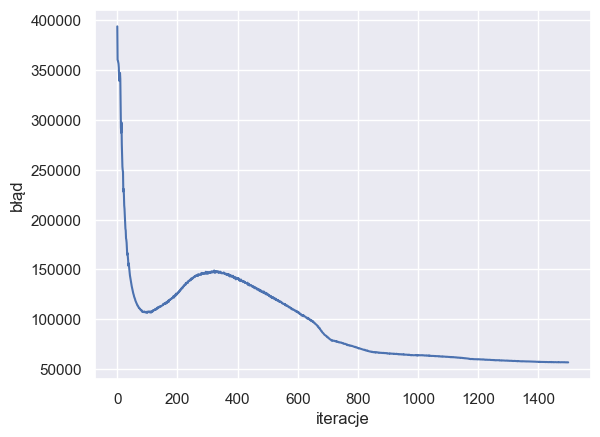

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(iter_error)), iter_error)
ax.set_xlabel('iteracje')
ax.set_ylabel('błąd')
print(iter_error[-1]/training_data.shape[0])

In [7]:
from run_multiple_models import run_rbms

testing_learning_rates = [0.05, 0.1, 0.2, 0.4]
rbms = [RBM(training_data, 12, learning_rate=rate, iterations=1000, random_seed=42) for rate in testing_learning_rates]
test_results = run_rbms(rbms)


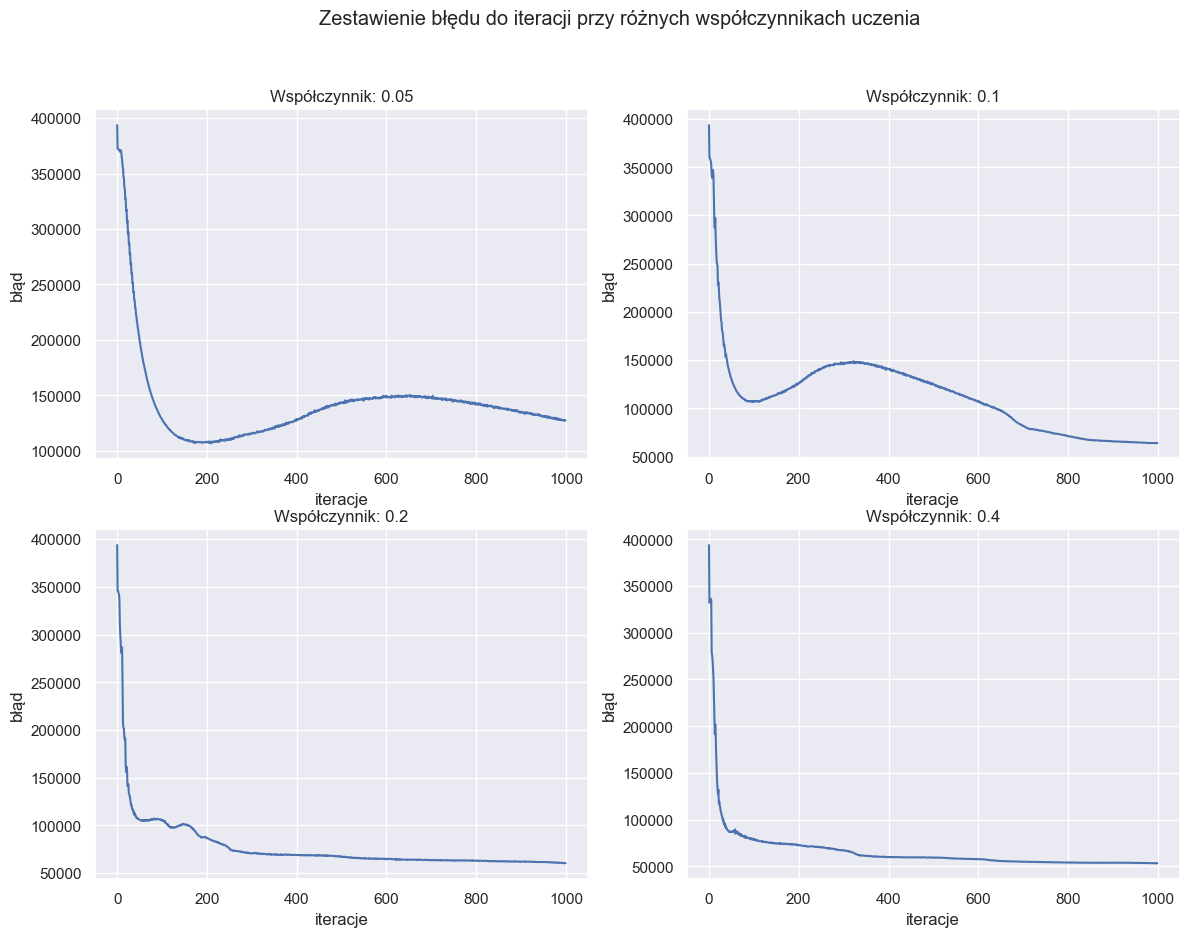

In [10]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Zestawienie błędu do iteracji przy różnych współczynnikach uczenia')
for index, result in enumerate(test_results):
    ax = fig.add_subplot(2,2,index+1)
    rbm, error = result
    ax.plot(range(len(error)), error)
    ax.set_title('Współczynnik: '+str(rbm.get_learning_rate()))
    ax.set_xlabel('iteracje')
    ax.set_ylabel('błąd')
plt.show()